# INET 4061 FINAL PROJECT

By: Peter Genatempo & Tianyi Wei

# **OVERVIEW**

### CONTEXT

The following notebook creates machine learning models in order to identify cargo ships in San Francisco Bay and San Pedro Bay areas of California. Image data is provided by Planet using satellite constellations to capture images of Earth.

### IMPORTANCE

There are many ways in which this could be applied in the real world outside of just cargo ships with things such as planes, trucks, or trains. However, identifying cargo ships is especially important in todays world to monitor port activity for defense and intelligence reasons or simply to monitor complex supply chains across the globe.

### CONTENT

Image data consists of 4,000 80x80 RGB images that are labeled with either a "ship" (value 1) or "no-ship" (value 0) classification.  The pixel value data for each image is sorted as a list of 19,200 integers within the data column.  The first 6,400 entries contain the red channel values, the next 6,400 the green, and the final 6,400 the blue.  The image is stored in row-major order, so that the first 80 entries of the array are the red channel values of the first row of the image and so on.

There are 1,000 images that are labeled as "ship".  All the images in this class are near-centered on the body of a single ship.  These images include ships of all different sizes, orientations, and atmospheric collection conditions.

The remaining 3,000 images are labeled as "no-ship" and fall into three different groups.  The first group is a random sample of different landcover features - water, vegetation, bare earth, buildings, etc. - that do not include any portion of a ship.  The next group are "partial ships" that contain only a portion of a ship, but not enough to meet the full definition of the "ship" class.  The last group are images that have previously been mislabeled by machine learning models, typically because of bright pixels or strong linear features.


# **DATA**

Dataset is downloadable at https://www.kaggle.com/rhammell/ships-in-satellite-imagery. All credit goes to kaggle user rhammell for providing public access to this data.

In [ ]:
# load packages
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import json

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from tensorflow.keras import optimizers

from IPython.display import Image

%matplotlib inline

In [ ]:
# load json file data
#with open('INET_Final_Data/shipsnet.json') as data_file:
#    dataset = json.load(data_file)
    
with open('shipsnet.json') as data_file:
    dataset = json.load(data_file)

# convert json data into dataframe
Shipsnet = pd.DataFrame(dataset)

In [ ]:
# check for null values
Shipsnet.isnull().values.any()

False

In [ ]:
Shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


# EXPLORATORY DATA ANALYSIS

In [ ]:
# shape of dataframe
np.shape(Shipsnet)

(4000, 4)

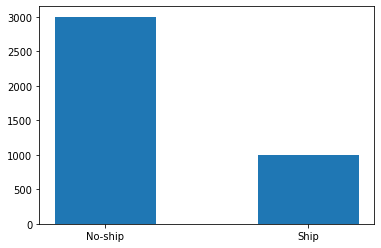

Number of images with ship:  1000
Number of images with no ship:  3000


In [ ]:
ship_count = len(Shipsnet[Shipsnet['labels']==1])
no_ship_count = len(Shipsnet[Shipsnet['labels']==0])

class_name = ["No-ship","Ship"]
plt.bar(class_name, [no_ship_count,ship_count],width=0.5)
plt.show()
print("Number of images with ship: ", ship_count)
print("Number of images with no ship: ", no_ship_count)

In [ ]:
# Extract data and labels
x = np.array(dataset["data"]).astype('uint8')
y = np.array(dataset["labels"]).astype('uint8')

In [ ]:
# Normalize and reshape image data into 80 * 80 *3 for display
xReshape = np.reshape(x,(-1,3,80,80)).transpose([0,2,3,1])
xReshape = xReshape/255

print(xReshape.shape)

(4000, 80, 80, 3)


## Display some examples of images

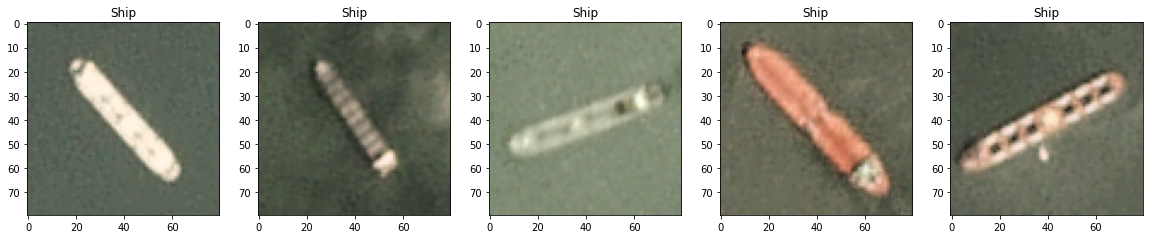

In [ ]:
# "Ship" class
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20,8)

class_name = ["No-ship","Ship"]

for i in range(5):
  ax[i].imshow(xReshape[i])
  ax[i].title.set_text(class_name[y[i]])

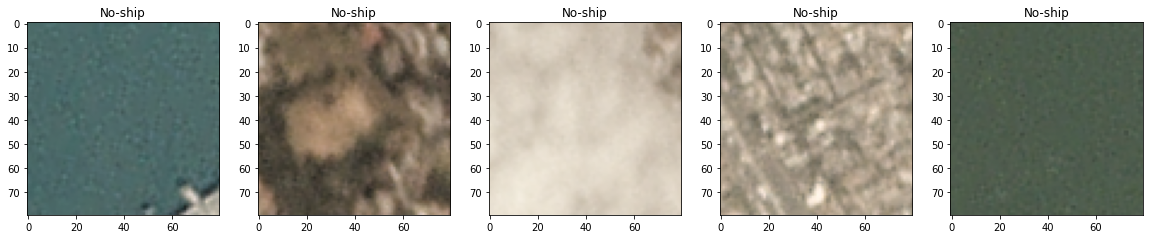

In [ ]:
# "No-ship" class type 1: landcover features
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20,8)

for i in range(5):
  ax[i].imshow(xReshape[1000+i])
  ax[i].title.set_text(class_name[y[1000+i]])

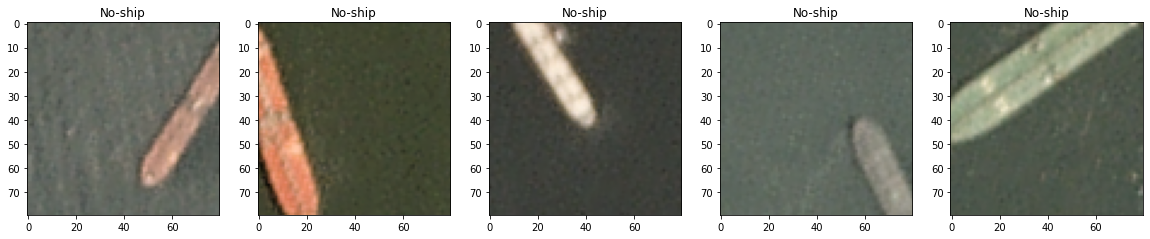

In [ ]:
# "No-ship" class type 2: partial ship
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20,8)

for i in range(5):
  ax[i].imshow(xReshape[2000+i])
  ax[i].title.set_text(class_name[y[2000+i]])

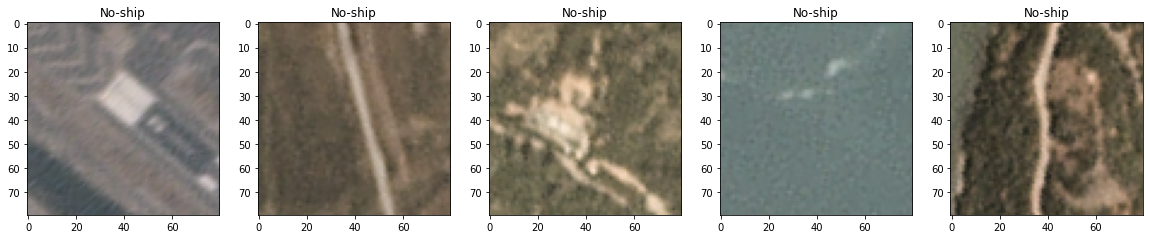

In [ ]:
# "No-ship" class type 3: bright pixels or strong linear feature
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(20,8)

for i in range(5):
  ax[i].imshow(xReshape[3000+i])
  ax[i].title.set_text(class_name[y[3000+i]])

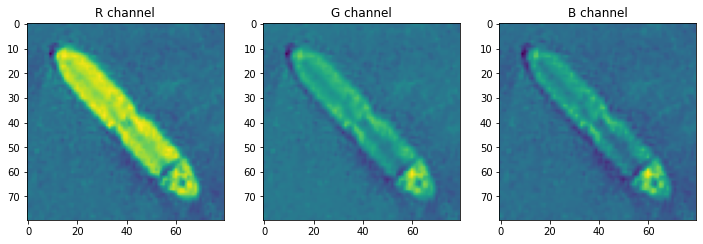

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12,8)

channel_name = ["R channel", "G channel", "B channel"]
for i in range(3):
  ax[i].imshow(xReshape[3,:,:,i])
  ax[i].title.set_text(channel_name[i])

From the figures above, we can see that the image data consists of three color channels: red (R), green (G), blue (B). Therefore, there are two ways to shape our image data: 

1. 1-d vector with values for each pixel (19200,)
2. 3-d volume with dimension height(80) * width(80) * depth(3), where depth represents the number of color channels. 

For the first input shape, we can build an SVM model and a dense neural network to classify the images. For the second input shape, we leverage a convolutional neural network that can handle image data in their raw shape. 

# **Model**

In [ ]:
# Split data into training set, validation set, and test set
x_Btrain,x_test,y_Btrain,y_test = train_test_split(xReshape,y,test_size=500,random_state=5)
x_train,x_val,y_train,y_val = train_test_split(x_Btrain,y_Btrain,test_size=500,random_state=5)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3000, 80, 80, 3)
(500, 80, 80, 3)
(500, 80, 80, 3)
(3000,)
(500,)
(500,)


In [ ]:
# Encode labels with one-hot encoding 
y_train_categorical = to_categorical(y_train,num_classes=2)
y_val_categorical = to_categorical(y_val,num_classes=2)
y_test_categorical = to_categorical(y_test,num_classes=2)

# Flatten image data into a 1-d vector
x_train_flatten = x_train.reshape(3000, -1)
x_val_flatten = x_val.reshape(500,-1)
x_test_flatten = x_test.reshape(500,-1)

## SVM

A SVM classifier looks for a hyper-plane that can best separate data in different classes. If the class boundary is not linear, a kernel trick can be applied to transform the non-separable problem to a separable problem. 

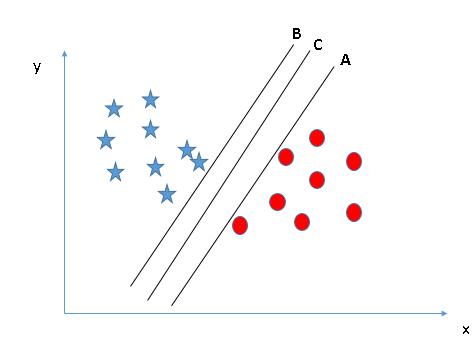

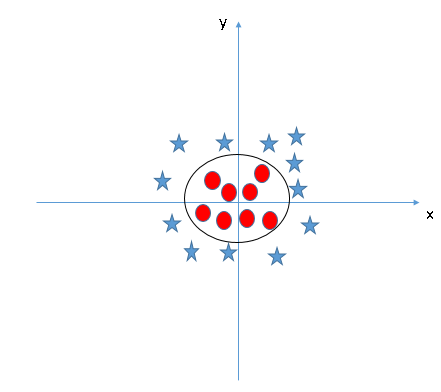

source: https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

In [ ]:
# SVM
from sklearn import svm
from sklearn.model_selection import GridSearchCV

SVM = svm.SVC()
param = {'C':[0.1,1,10],'gamma':[0.001,0.1,1],'kernel':['rbf','poly']}
model_svm = GridSearchCV(SVM,param)

In [ ]:
model_svm.fit(x_train_flatten,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [ ]:
model_svm.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
from sklearn import svm
model_svm = svm.SVC(C=10, kernel='rbf',gamma=0.001)
model_svm.fit(x_train_flatten,y_train)

SVC(C=10, gamma=0.001)

In [ ]:
print("Mean accuracy on test set: ", model_svm.score(x_test_flatten,y_test))

Mean accuracy on test set:  0.976


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_svm = model_svm.predict(x_test_flatten)
confusion_svm = confusion_matrix(y_test,y_pred_svm)


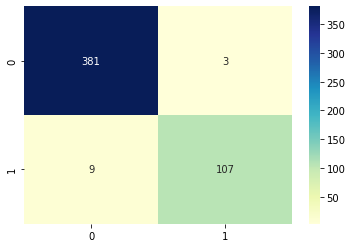

In [ ]:
sns.heatmap(confusion_svm, annot=True,fmt="d",cmap="YlGnBu")

## Fully connected (Dense) neural network
A fully connected neural network (FCNN) is a type of artificial neural network where every neuron in a layer is connected to every neuron in the next layer with some assigned weight. A typical FCNN has an input layer, hidden layer(s), and an output layer. Within each layer, the FCNN takes an input vector and multiplies it by a weight matrix plus a bias term to obtain a weighted sum. Then an activation function is appplied to the weighted sum, which results in values for neurons in the next layer. After passing through all layers, the predicted values in the output layer are passed into a loss function that computes the difference between the predicted values and the true values. We minimize the loss function with respect to all weights using some gradient-based methods. Then we can use the learned weights to make predictions for new data.

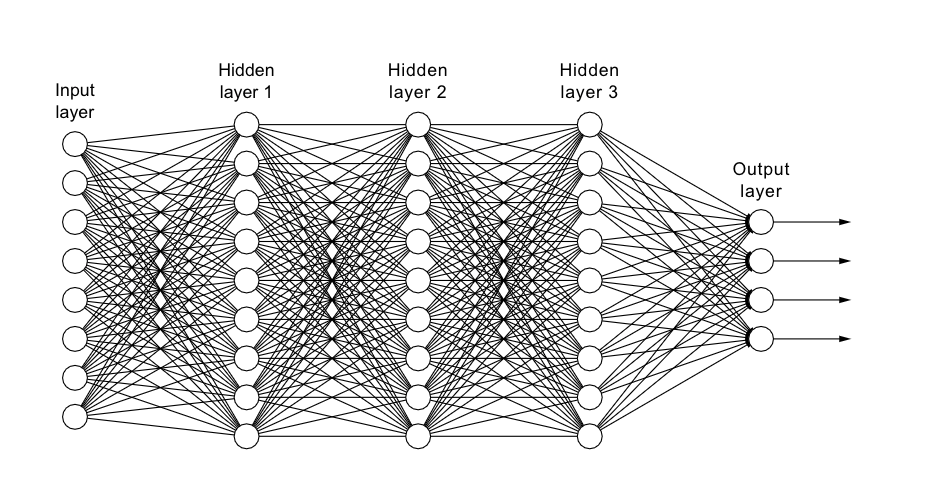

Source: https://livebook.manning.com/book/probabilistic-deep-learning-with-python/chapter-2/v-5/

In [ ]:
# Fully connected neural network
from tensorflow.keras import Input

model_fcnn = Sequential()

model_fcnn.add(Input(shape=(19200,)))
model_fcnn.add(Dense(256, activation='relu'))
model_fcnn.add(Dense(128, activation='relu'))
model_fcnn.add(Dense(64, activation='relu'))
model_fcnn.add(Dense(2,activation='softmax'))

model_fcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_fcnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               4915456   
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 2)                 130       
                                                                 
Total params: 4,956,738
Trainable params: 4,956,738
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_fcnn = model_fcnn.fit(x_train_flatten,
                              y_train_categorical,
                              batch_size=64,
                              epochs=10,
                              validation_data=[x_val_flatten,y_val_categorical])

Epoch 1/10
47/47 [==============================] - 2s 36ms/step - loss: 0.9202 - accuracy: 0.7407 - val_loss: 0.3661 - val_accuracy: 0.8460
Epoch 2/10
47/47 [==============================] - 2s 33ms/step - loss: 0.4266 - accuracy: 0.8283 - val_loss: 0.3517 - val_accuracy: 0.8680
Epoch 3/10
47/47 [==============================] - 2s 32ms/step - loss: 0.3791 - accuracy: 0.8527 - val_loss: 0.2612 - val_accuracy: 0.8960
Epoch 4/10
47/47 [==============================] - 2s 32ms/step - loss: 0.3325 - accuracy: 0.8687 - val_loss: 0.2675 - val_accuracy: 0.8880
Epoch 5/10
47/47 [==============================] - 2s 33ms/step - loss: 0.3451 - accuracy: 0.8640 - val_loss: 0.4696 - val_accuracy: 0.8180
Epoch 6/10
47/47 [==============================] - 2s 33ms/step - loss: 0.3154 - accuracy: 0.8763 - val_loss: 0.2242 - val_accuracy: 0.9200
Epoch 7/10
47/47 [==============================] - 2s 33ms/step - loss: 0.2956 - accuracy: 0.8833 - val_loss: 0.2232 - val_accuracy: 0.9120
Epoch 8/10
47

In [ ]:
test_accuracy = model_fcnn.evaluate(x_test_flatten,y_test_categorical,verbose=0)
print("Mean accuracy on test set: %.3f" % test_accuracy[1])

Mean accuracy on test set: 0.904


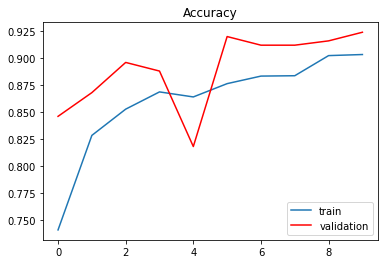

In [ ]:
plt.plot(history_fcnn.history['accuracy'])
plt.plot(history_fcnn.history['val_accuracy'],c='r')
plt.legend(["train","validation"],loc="lower right")
plt.title("Accuracy")
plt.show()

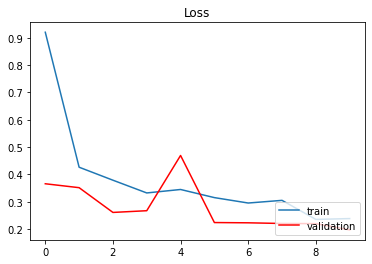

In [ ]:
plt.plot(history_fcnn.history['loss'])
plt.plot(history_fcnn.history['val_loss'],c='r')
plt.legend(["train","validation"],loc="lower right")
plt.title("Loss")
plt.show()

In [ ]:
y_pred_fcnn = model_fcnn.predict(x_test_flatten)
y_pred_fcnn = np.argmax(y_pred_fcnn,axis=1)
confusion_fcnn = confusion_matrix(y_test,y_pred_fcnn)

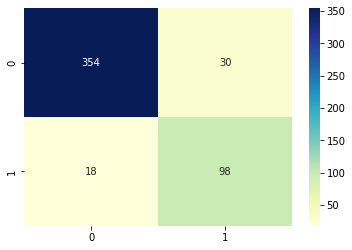

In [ ]:
sns.heatmap(confusion_fcnn, annot=True,fmt="d",cmap="YlGnBu")

## Convolutional neural network 

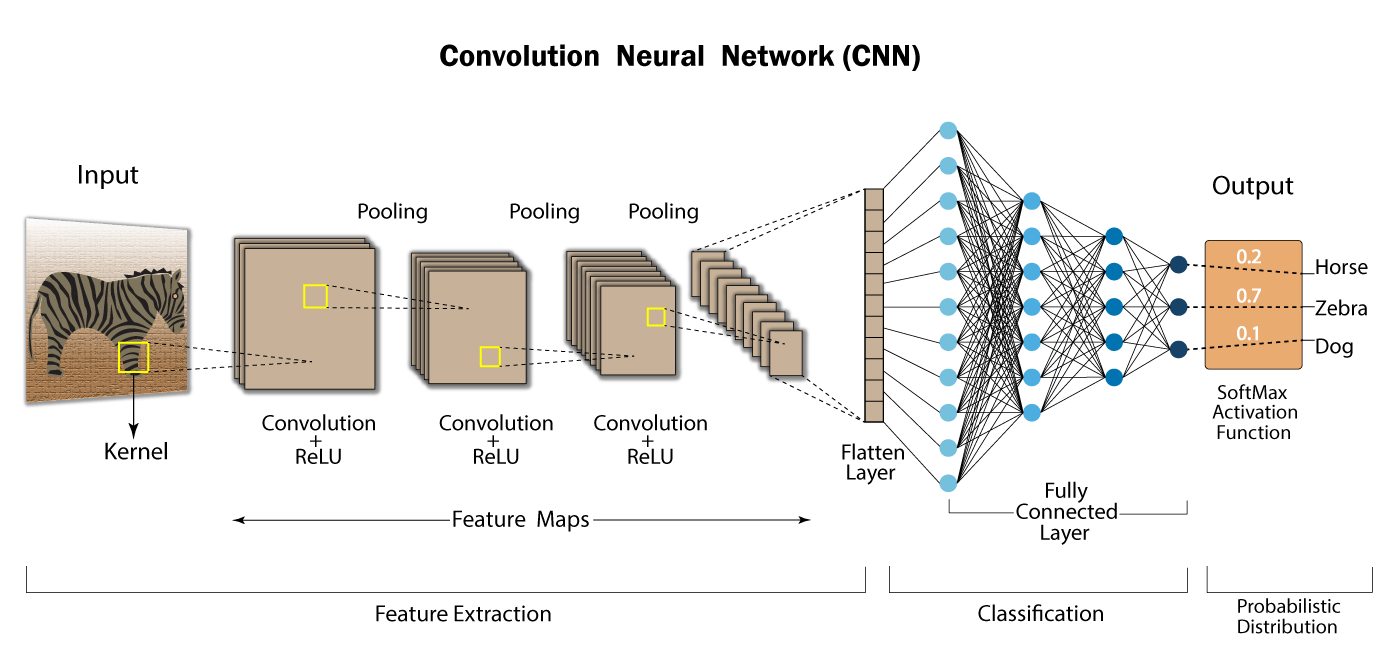

Source: https://www.analyticsvidhya.com/blog/2021/05/20-questions-to-test-your-skills-on-cnn-convolutional-neural-networks/

Unlike a FCNN that connects every neurons between layers, a convolutional neural network (CNN) takes an input image and connects a small batch of neighboring pixels to one neuron in the next convolutional layer. There are 3 main types of layers in a CNN: convolutional layers, pooling layers, and fully connected layers. 

- Convolutional layers: The weights in convolutional layers are stored in kernels. Each kernel is slid across the entire image data and multiply by the pixel value at the corresponding position. These values are added to generate one output value in the feature map. Then an activation function will be applied elementwise to the values in the resulting feature map. 

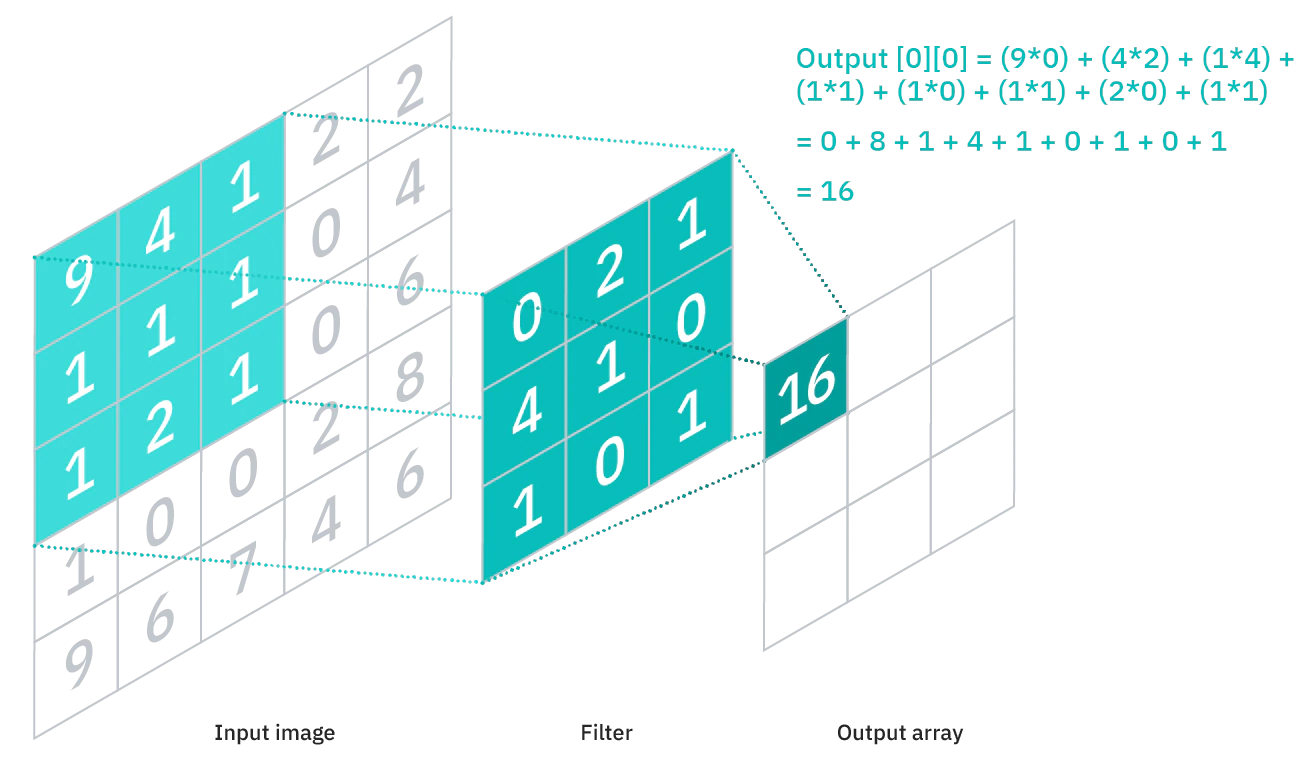

Source: https://docs.ecognition.com/eCognition_documentation/User%20Guide%20Developer/8%20Classification%20-%20Deep%20Learning.htm

- Pooling layers: Pooling is a subsampling technique in CNNs to reduce the spatial size (i.e. height and width) of the resulting feature maps. 

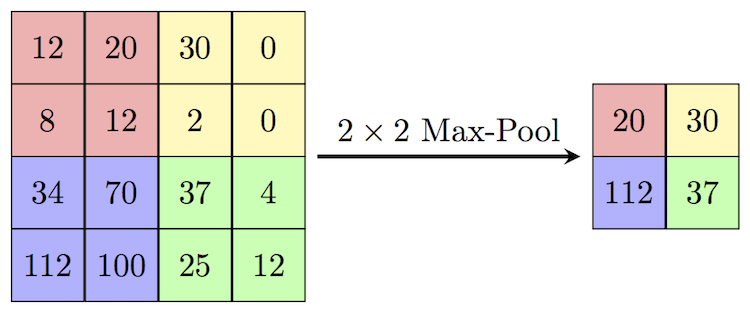

Source: https://paperswithcode.com/method/max-pooling

- Fully connected layer: The fully connected layer is the final layer in a CNN where the classification is done. It works the same as a FCNN. 


In [ ]:
batch_size = 128
kernel_size = (3,3)
pool_size = (2,2)

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32,kernel_size,padding="same",input_shape=(80,80,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(Conv2D(32,kernel_size,padding="same"))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=pool_size))

model_cnn.add(Conv2D(64,kernel_size,padding="same"))
model_cnn.add(Activation('relu'))
model_cnn.add(Conv2D(64,kernel_size,padding="same"))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=pool_size))

model_cnn.add(Flatten())
model_cnn.add(Dense(128))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(2))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 80, 80, 32)        896       
                                                                 
 activation_14 (Activation)  (None, 80, 80, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 80, 80, 32)        9248      
                                                                 
 activation_15 (Activation)  (None, 80, 80, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 40, 40, 64)        18496     
                                                      

In [ ]:
history_cnn = model_cnn.fit(x_train,y_train_categorical,
                      batch_size=64,
                      epochs=10,
                      validation_data=[x_val,y_val_categorical])

Epoch 1/10
47/47 [==============================] - 63s 1s/step - loss: 0.1961 - accuracy: 0.9230 - val_loss: 0.1565 - val_accuracy: 0.9380
Epoch 2/10
47/47 [==============================] - 63s 1s/step - loss: 0.1757 - accuracy: 0.9317 - val_loss: 0.1386 - val_accuracy: 0.9420
Epoch 3/10
47/47 [==============================] - 63s 1s/step - loss: 0.1172 - accuracy: 0.9533 - val_loss: 0.0981 - val_accuracy: 0.9600
Epoch 4/10
47/47 [==============================] - 63s 1s/step - loss: 0.1155 - accuracy: 0.9557 - val_loss: 0.1284 - val_accuracy: 0.9480
Epoch 5/10
47/47 [==============================] - 63s 1s/step - loss: 0.1016 - accuracy: 0.9577 - val_loss: 0.1064 - val_accuracy: 0.9680
Epoch 6/10
47/47 [==============================] - 63s 1s/step - loss: 0.0700 - accuracy: 0.9757 - val_loss: 0.0700 - val_accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 63s 1s/step - loss: 0.0317 - accuracy: 0.9870 - val_loss: 0.0431 - val_accuracy: 0.9860
Epoch 8/10
47/47 [==

In [ ]:
model_cnn.evaluate(x_test,y_test_categorical,verbose=1)

16/16 [==============================] - 3s 171ms/step - loss: 0.0809 - accuracy: 0.9860


[0.08092697709798813, 0.9860000014305115]

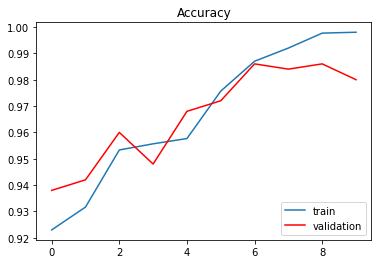

In [ ]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'],c='r')
plt.legend(["train","validation"],loc="lower right")
plt.title("Accuracy")
plt.show()

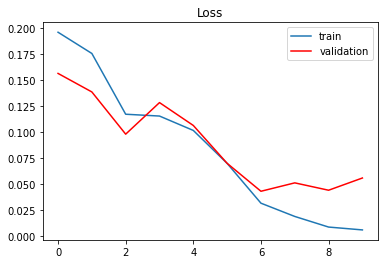

In [ ]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'],c='r')
plt.legend(["train","validation"],loc="upper right")
plt.title("Loss")
plt.show()

In [ ]:
y_pred_cnn = model_cnn.predict(x_test)
y_pred_cnn = np.argmax(y_pred_cnn,axis=1)
confusion_cnn = confusion_matrix(y_test,y_pred_cnn)

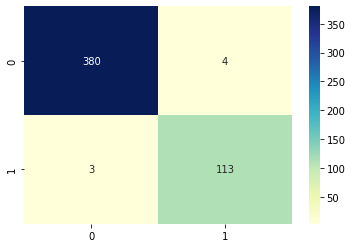

In [ ]:
sns.heatmap(confusion_cnn, annot=True,fmt="d",cmap="YlGnBu")

## Model comparison

In [ ]:
print("Mean accuracy on test set for svm: ", model_svm.score(x_test_flatten,y_test))
print("Mean accuracy on test set for fcnn: %.3f" % model_fcnn.evaluate(x_test_flatten,y_test_categorical,verbose=0)[1])
print("Mean accuracy on test set for cnn: %.3f" % model_cnn.evaluate(x_test,y_test_categorical,verbose=0)[1])

Mean accuracy on test set for svm:  0.976
Mean accuracy on test set for fcnn: 0.904
Mean accuracy on test set for cnn: 0.986


# **CONCLUSION**

Comparing the three models' performance on the test set, SVM classifier achieves 97.6% accuracy, FCNN classifier achieves 90.4% accuracy, and CNN classifier achieves 98.6% accuracy. Based on the accuracy on test set, we achieve the best accuracy with the CNN classifier. In terms of runtime, it took FCNN 2 seconds to run one epoch while it took CNN 63 seconds to run one epoch. It took over an hour for grid search cross validation to find the optimal parameters for our SVM classifier. Although it took the least time for FCNN to be trained on the training data, we think that accuracy is the most important measure in a classification problem. Therefore, we would choose the CNN classifier for our task. 

Here is how we can use CNN to classify a harbor image: we pass the new image into the CNN, and CNN will output a probability distribution over the two classes (No-ship and Ship). Then we can classify the image as the class with higher probability. In the example below, we would say that the image belongs to class 1 (Ship).  



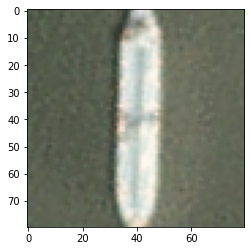

In [ ]:
plt.imshow(x_test[6])
plt.show()

In [ ]:
new_data = x_test[6].reshape([1,80,80,3])

In [ ]:
y_pred = model_cnn.predict(new_data)
print("Probability that new image belongs to class 0 (No-ship): %.3f" % y_pred[0][0])
print("Probability that new image belongs to class 1 (Ship): %.3f" % y_pred[0][1])

Probability that new image belongs to class 0 (No-ship): 0.007
Probability that new image belongs to class 1 (Ship): 0.993


Something that we think would be interesting to do given more time would be to see if we could identify the different subsets of the "no-ship" category.  It might be useful to classify whether or not an image is strictly land or if there is a partial cargo ship.  This could help in identifying ships that are cut off from the frame of the image and would be beneficial if looking to count the number of ships in a harbor.  Currently our solution only works for identifying images that contain a full ship so given some more time this would be an interesting addition to the problem to explore.